In [1]:
import itertools
import os
import collections
import sys
import traceback
import matplotlib
import re
import glypy
from glypy import monosaccharides, glycans, motifs
from glypy.composition import Composition, composition_transform, glycan_composition
from glypy.structure import (glycan, monosaccharide, substituent,
                              Anomer, Configuration, SuperClass,
                              Substituent, Glycan, Monosaccharide,
                              crossring_fragments)
from glypy.io.nomenclature import identity
from glypy.io import glycoct, glycomedb, iupac
from glypy import plot
from glypy.algorithms import subtree_search, similarity, database
from glypy import tests
%matplotlib inline
from IPython.display import set_matplotlib_formats, display

set_matplotlib_formats("svg")

import logging
logging.basicConfig(level="DEBUG")

(RES 1b:x-dglc-HEX-x:x 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=0.4875 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0xb7b5ac8>)

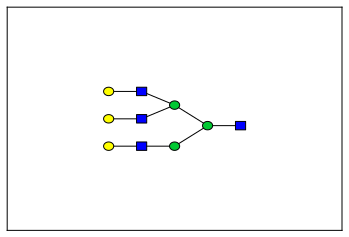

In [2]:
plot.plot(tests.load("branchy_glycan"))

In [3]:
#db = database.dbopen("human_n_glycans_deduplicated.db")

In [4]:
#compositions = map(glycan_composition.from_glycan, db)

for i, c in enumerate(compositions):
    clone_coherent = c == c.clone()
    try:
        parse_coherent = c == glycan_composition.parse(c.serialize())
    except KeyError, e:
        print i, c, e
    if clone_coherent and parse_coherent:
        continue
    if not clone_coherent:
        print i, c, c.clone()
    if not parse_coherent:
        print i, c.serialize(), glycan_composition.parse(c.serialize()).serialize(),\
              c.mass(), glycan_composition.parse(c.serialize()).mass()

In [5]:
m = glycan_composition._from_iupac_lite("Fuc")
glycan_composition.drop_stem(m)
m

MonosaccharideResidue(6-dHex)

In [6]:
Substituent("methyl").mass()

16.03130012828

In [7]:
Composition("H2O").mass

18.0105646837

In [8]:
reload(composition_transform)
reload(glycan_composition)
reload(glycan)


<module 'glypy.structure.glycan' from 'd:\dropbox\glycomicssandbox\glypy\glypy\structure\glycan.pyc'>

In [9]:
ncore = composition_transform.derivatize(glycans["N-Linked Core"], "methyl")
ncore_comp = composition_transform.derivatize(glycan_composition.from_glycan(glycans["N-Linked Core"]), 'methyl')
derive_from = glycan_composition.from_glycan(ncore)
print ncore.total_composition(), ncore_comp.total_composition(), derive_from.total_composition()
print ncore.mass(), ncore_comp.mass(), derive_from.mass()

Composition({'H': 92, 'C': 51, 'O': 26, 'N': 2}) Composition({'H': 92, 'C': 51, 'N': 2, 'O': 26, 'H+': 0}) Composition({'H': 92, 'C': 51, 'N': 2, 'O': 26, 'H+': 0})
1148.59383107 1148.59383107 1148.59383107


In [10]:
for k in derive_from:
    print k, k.total_composition()

Man Composition({'H': 16, 'C': 9, 'O': 5, 'H+': 0})
Glc2NAc Composition({'H': 19, 'C': 11, 'N': 1, 'O': 5, 'H+': 0})


In [11]:
pman = composition_transform.derivatize(glycan_composition._from_iupac_lite("Man"), "methyl")
pglcnac = composition_transform.derivatize(glycan_composition._from_iupac_lite("Glc2NAc"), "methyl")

In [12]:
gc = glycan_composition.GlycanComposition()
gc[pman] = 3
gc[pglcnac] = 2
gc.mass() - Composition("H2O").mass

1102.5519662566198

In [13]:
gc._composition_offset

Composition({'H': 2, 'O': 1, 'H+': 0})

In [14]:
(245.1263 * 2) + (204.0998 * 3) + 46.0419 - Composition("H2O").mass

1130.5833353162998

In [15]:
derive_from.composition_offset

Composition({'H': 6, 'C': 2, 'O': 1, 'H+': 0})

In [16]:
ncore_comp.composition_offset

Composition({'H': 6, 'C': 2, 'O': 1, 'H+': 0})

In [17]:
ncore = (glycans["N-Linked Core"])
derive_from2 = glycan_composition.from_glycan(ncore)
print ncore.total_composition(), derive_from2.total_composition()
print ncore.mass(), derive_from2.mass()

Composition({'H': 58, 'C': 34, 'O': 26, 'N': 2}) Composition({'H': 58, 'C': 34, 'N': 2, 'O': 26, 'H+': 0})
910.327779978 910.327779978


In [18]:
for k in derive_from2:
    print k, k.total_composition()

Man Composition({'H': 10, 'C': 6, 'O': 5, 'H+': 0})
Glc2NAc Composition({'H': 13, 'C': 8, 'N': 1, 'O': 5, 'H+': 0})


In [19]:
derive_from.serialize()

'{Man:3, Glc2NAc:2}'

In [20]:
man = glycan_composition._from_iupac_lite("Man")

In [23]:
man.name() == pman.name()

True

In [29]:
derive_from["Man"]

3

In [39]:
x=derive_from.clone()

In [37]:
x.update({"Man": 12})

In [41]:
x["Man"]

3

In [43]:
x = glycan_composition.GlycanComposition(Man=3)

In [47]:
x.update(**{"Man": 12})

In [48]:
x

{MonosaccharideResidue(Man): 12, MonosaccharideResidue(Glc2NAc): 2}